This IPython Notebook illustrates how to use the MGXS module to formulate an equivalent coarse-mesh finite difference (CMFD) diffusion representation of a problem. The CMFD representation of the a problem can serve many purposes. During the Monte Carlo solve, it can help accelerate the source convergence [cite Herman]. The CMFD diffusion operator can also be used as a low-order operator to solve a transient problem with an Indirect Monte Carlo method [cite my thesis]. In particular, this Notebook illustrates the following features:

* Calculation of all multi-group cross sections for a **fuel assembly** required to form the CMFD diffusion operator
* Automated creation, manipulation and storage of `MGXS` with **`openmc.mgxs.Library`**
* **Validation** of CMFD representation by comparing the MC pin powers with pin powers computed from solving the eigenvalue problem with the CMFD diffusion representation.

## Generate Input Files

In [1]:
import math
import pickle

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

import openmc
import openmc.mgxs
from openmc.openmoc_compatible import get_openmoc_geometry
from scipy.sparse.linalg import spsolve

%matplotlib inline

/Users/samuelshaner/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H1')
b10 = openmc.Nuclide('B10')
o16 = openmc.Nuclide('O16')
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
zr90 = openmc.Nuclide('Zr90')

With the nuclides we defined, we will now create three materials for the fuel, water, and cladding of the fuel pins.

In [3]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

With our three materials, we can now create a `Materials` object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials object
materials_file = openmc.Materials((fuel, water, zircaloy))

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a square array of fuel pins and control rod guide tubes for which we can use OpenMC's lattice/universe feature. The basic universe will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces for fuel and clad, as well as the outer bounding surfaces of the problem.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='reflective')
min_y = openmc.YPlane(y0=-10.71, boundary_type='reflective')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

With the surfaces defined, we can now construct a fuel pin cell from cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
fuel_pin_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

Likewise, we can construct a control rod guide tube with the same surfaces.

In [7]:
# Create a Universe to encapsulate a control rod guide tube
guide_tube_universe = openmc.Universe(name='Guide Tube')

# Create guide tube Cell
guide_tube_cell = openmc.Cell(name='Guide Tube Water')
guide_tube_cell.fill = water
guide_tube_cell.region = -fuel_outer_radius
guide_tube_universe.add_cell(guide_tube_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='Guide Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
guide_tube_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='Guide Tube Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
guide_tube_universe.add_cell(moderator_cell)

Using the pin cell universe, we can construct a 17x17 rectangular lattice with a 1.26 cm pitch.

In [8]:
# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel Assembly')
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2

Next, we create a NumPy array of fuel pin and guide tube universes for the lattice.

In [9]:
# Create array indices for guide tube locations in lattice
template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8,
                       11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8,
                       8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])

# Initialize an empty 17x17 array of the lattice universes
universes = np.empty((17, 17), dtype=openmc.Universe)

# Fill the array with the fuel pin and guide tube universes
universes[:,:] = fuel_pin_universe
universes[template_x, template_y] = guide_tube_universe

# Store the array of universes in the lattice
assembly.universes = universes

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the assembly and then assign it to the root universe.

In [10]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [11]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

In [12]:
# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 2500 particles.

In [13]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 2500

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a `Plots` file that we can use to verify that our fuel assembly geometry was created successfully.

In [14]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.pixels = [250, 250]
plot.width = [-10.71*2, -10.71*2]
plot.color_by = 'material'

# Instantiate a Plots object, add Plot, and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [15]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

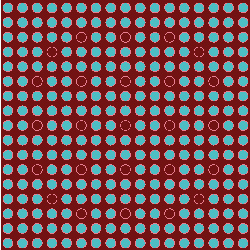

In [16]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have a nice array of fuel and guide tube pin cells with fuel, cladding, and water!

## Create an MGXS Library

Now we are ready to generate multi-group cross sections! First, let's define a 2-group structure using the built-in `EnergyGroups` class.

In [17]:
# Instantiate a 2-group EnergyGroups object
groups = openmc.mgxs.EnergyGroups()
groups.group_edges = np.array([0., 4.0, 20.0e6])

Next, we will instantiate an `openmc.mgxs.Library` for the energy groups with the fuel assembly geometry.

In [18]:
# Initialize a 2-group MGXS Library for OpenMOC
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups = groups

Now, we must specify to the `Library` which types of cross sections to compute. In particular, the following are the multi-group cross section `MGXS` subclasses that are mapped to string codes accepted by the `Library` class:

* `TotalXS` (`"total"`)
* `DiffusionCoefficient` (`"diffusion-coefficient"`)
* `TransportXS` (`"transport"` or `"nu-transport` with `nu` set to `True`)
* `AbsorptionXS` (`"absorption"`)
* `CaptureXS` (`"capture"`)
* `FissionXS` (`"fission"` or `"nu-fission"` with `nu` set to `True`)
* `KappaFissionXS` (`"kappa-fission"`)
* `ScatterXS` (`"scatter"` or `"nu-scatter"` with `nu` set to `True`)
* `ScatterMatrixXS` (`"scatter matrix"` or `"nu-scatter matrix"` with `nu` set to `True`)
* `Chi` (`"chi"`)
* `ChiPrompt` (`"chi prompt"`)
* `InverseVelocity` (`"inverse-velocity"`)
* `CMFDCoupling` (`"cmfd-coupling"` or `"nu-cmfd-coupling"` or `"cmfd-coupling-correction"` or `"nu-cmfd-coupling-correction"`)
* `PromptNuFissionXS` (`"prompt-nu-fission"`)
* `DelayedNuFissionXS` (`"delayed-nu-fission"`)
* `ChiDelayed` (`"chi-delayed"`)
* `Beta` (`"beta"`)

In this case, we will create the multi-group cross sections needed to create a CMFD diffusion representation of the problem. In particular, we will define `"cmfd-coupling"`, `"cmfd-coupling-correction"`, `"nu-fission"`, `'"scatter-matrix"`, `"scatter"` `"absorption"`, and `"chi"` cross sections for our `Library`. We will also create a `"kappa-fission"` multi-group cross section to use in computing the pin powers from the CMFD diffusion problem.

**Note**: A variety of different approximate transport-corrected total multi-group cross sections (and corresponding scattering matrices) can be found in the literature. At the present time, the `openmc.mgxs` module only supports the `"P0"` transport correction. This correction can be turned on and off through the boolean `Library.correction` property which may take values of `"P0"` (default) or `None`.

In [19]:
# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['cmfd-coupling', 'cmfd-coupling-correction', 'nu-fission', 'scatter matrix', 'scatter', 'absorption', 'chi', 'kappa-fission']

Now we must specify the type of domain over which we would like the `Library` to compute multi-group cross sections. The domain type corresponds to the type of tally filter to be used in the tallies created to compute multi-group cross sections. At the present time, the `Library` supports `"material"`, `"cell"`, `"universe"`, and `"mesh"` domain types. We will use a `"mesh"` domain type here to compute cross sections in each of the mesh cells in the fuel assembly geometry since the CMFD diffusion problem is only currently set up on a cartesian mesh.

In [41]:
# Specify a "cell" domain type for the cross section tally filters
mgxs_lib.domain_type = 'mesh'

mgxs_mesh = openmc.Mesh(mesh_id=1)
mgxs_mesh.type = 'regular'
mgxs_mesh.dimension = [17,17]
mgxs_mesh.lower_left  = [-10.71, -10.71]
mgxs_mesh.upper_right = [ 10.71,  10.71]

# Specify the mesh domain over which to compute multi-group cross sections
mgxs_lib.domains = [mgxs_mesh]

/Users/samuelshaner/repos/openmc-sam/openmc/mixin.py:61: IDWarning: Another Mesh instance already exists with id=1.
  warn(msg, IDWarning)


Lastly, we use the `Library` to construct the tallies needed to compute all of the requested multi-group cross sections in each mesh cell. Note that the correction for the `"scatter matrix"` is turned off. The correction is turned off by default for the `"scatter"` MGXS (which is used to represent outscatter) so we must also turn off the correction for the `"scatter matrix"` MGXS (which is used to represent inscatter).

In [21]:
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()
mgxs_lib.get_mgxs(mgxs_mesh, 'scatter matrix').correction = None

The tallies can now be export to a "tallies.xml" input file for OpenMC. 

In [22]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies_file, merge=True)

In addition, we instantiate a kappa-fission mesh tally to compare with CMFD.

In [23]:
# Instantiate a tally Mesh
mesh = openmc.Mesh(mesh_id=2)
mesh.type = 'regular'
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.upper_right = [+10.71, +10.71]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter]
tally.scores = ['kappa-fission']

# Add tally to collection
tallies_file.append(tally)

In [24]:
# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

/Users/samuelshaner/repos/openmc-sam/openmc/mixin.py:61: IDWarning: Another MeshFilter instance already exists with id=1.
  warn(msg, IDWarning)
/Users/samuelshaner/repos/openmc-sam/openmc/mixin.py:61: IDWarning: Another EnergyFilter instance already exists with id=2.
  warn(msg, IDWarning)
/Users/samuelshaner/repos/openmc-sam/openmc/mixin.py:61: IDWarning: Another EnergyoutFilter instance already exists with id=4.
  warn(msg, IDWarning)


In [25]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object. 

In [26]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.50.h5')

The statepoint is now ready to be analyzed by the `Library`. We simply have to load the tallies from the statepoint into the `Library` and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [27]:
# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

Voila! Our multi-group cross sections are now ready to rock 'n roll!

## Extracting MGXS and solving the CMFD diffusion problem

First, we extract all the MGXS in their matrix form. The matrix form can only be used with a mesh domain and allows a group-to-group and cell-to-cell interaction matrix to be set up for each MGXS type.

In [28]:
# Retrieve the mgxs matrices
stream = mgxs_lib.get_mgxs(mgxs_mesh, 'cmfd-coupling').get_xs(matrix=True)
stream_corr = mgxs_lib.get_mgxs(mgxs_mesh, 'cmfd-coupling-correction').get_xs(matrix=True)
absorption = mgxs_lib.get_mgxs(mgxs_mesh, 'absorption').get_xs(matrix=True)
out_scatter = mgxs_lib.get_mgxs(mgxs_mesh, 'scatter').get_xs(matrix=True)
in_scatter = mgxs_lib.get_mgxs(mgxs_mesh, 'scatter matrix').get_xs(row_column='outin', matrix=True)
nu_fission = mgxs_lib.get_mgxs(mgxs_mesh, 'nu-fission').get_xs(matrix=True)
chi = mgxs_lib.get_mgxs(mgxs_mesh, 'chi').get_xs(matrix=True)
kappa_fission = mgxs_lib.get_mgxs(mgxs_mesh, 'kappa-fission').get_xs(matrix=True)

/Users/samuelshaner/repos/openmc-sam/openmc/tallies.py:1852: RuntimeWarning: invalid value encountered in true_divide
  self_rel_err = data['self']['std. dev.'] / data['self']['mean']
/Users/samuelshaner/repos/openmc-sam/openmc/tallies.py:1853: RuntimeWarning: invalid value encountered in true_divide
  other_rel_err = data['other']['std. dev.'] / data['other']['mean']
/Users/samuelshaner/repos/openmc-sam/openmc/tallies.py:1854: RuntimeWarning: invalid value encountered in true_divide
  new_tally._mean = data['self']['mean'] / data['other']['mean']


Now, we can combine the individual reaction matrices to get the production and destruction matrices.

In [29]:
# Form the production and destruction matrices
prod_matrix = chi.multiply(nu_fission)
dest_matrix = stream + stream_corr + absorption + out_scatter - in_scatter

The production and destruction matrices are now ready to be used in solving the CMFD diffusion eigenvalue problem. In order to solve this problem, we will set up a simple power iteration eigenvalue solver.

In [30]:
# Solve the eigenvalue problem
def compute_eigenvalue(A, M, flux, tolerance=1.e-6):

    # Ensure flux is a 1D array                                                                                                         
    flux = flux.flatten()

    # Compute the initial source                                                                                                        
    old_source = M * flux
    norm = old_source.mean()
    old_source  = old_source / norm
    flux  = flux / norm
    k_eff = 1.0

    print('initial k {}'.format((M*flux).sum() / (A*flux).sum()))

    for i in range(10000):

        # Solve linear system                                                                                
        flux = spsolve(A, old_source)

        # Compute new source                                                                                                            
        new_source = M * flux

        # Compute and set k-eff                                                                                                         
        k_eff = new_source.mean()

        # Scale the new source by 1 / k-eff                                                                                             
        new_source  = new_source / k_eff

        # Compute the residual                                                                                                          
        residual_array = (new_source - old_source) / new_source
        residual_array[residual_array == -np.inf] = 0.
        residual_array[residual_array ==  np.inf] = 0.
        residual_array = np.nan_to_num(residual_array)
        residual_array = np.square(residual_array)
        residual = np.sqrt(residual_array.mean())

        # Copy new source to old source                                                                                                 
        old_source = np.copy(new_source)

        print('eigen solve iter {:03d} resid {:1.5e} k-eff {:1.6f}'\
              .format(i, residual, k_eff))

        if residual < tolerance and i > 2:
            break

    return flux, k_eff

initial k 1.122661765127126
eigen solve iter 000 resid 1.54076e-02 k-eff 1.023724
eigen solve iter 001 resid 5.82787e-05 k-eff 1.023723
eigen solve iter 002 resid 8.80449e-07 k-eff 1.023723
eigen solve iter 003 resid 1.55232e-08 k-eff 1.023723


/Users/samuelshaner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


We can now use the eigenvalue solver to compute the flux for the CMFD diffusion problem.

In [ ]:
flux_guess = np.ones(np.prod(mgxs_mesh.dimension)*groups.num_groups)
flux, k_eff = compute_eigenvalue(dest_matrix, prod_matrix, flux_guess)

In order to confirm that neutron balance was maintained between MC and CMFD eigenvalue problems, we can compare the pin powers. Due to the usage of both track-length and analog estimators in the MGXS tallies and by neglecting the contribution from some of reactions (e.g. (n,2n)), the pin powers are not expected to agree exactly; however, we expect the pin powers to agree to well below 1%.

/Users/samuelshaner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


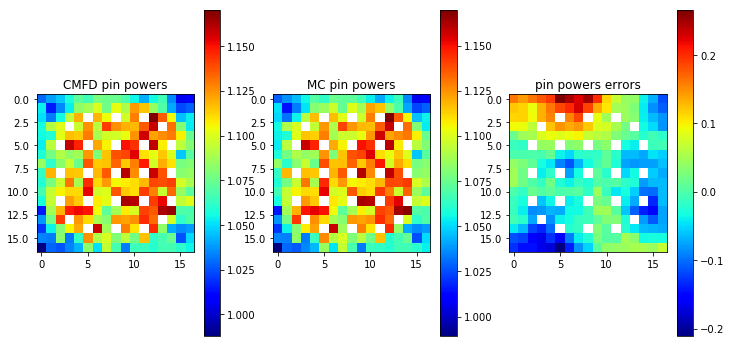

In [40]:
# Compute the CMFD pin powers
cmfd_pin_powers = kappa_fission * flux

# Get the Monte Carlo pin powers from the mesh tally 
mc_pin_powers = sp.get_tally(scores=['kappa-fission']).get_values(scores=['kappa-fission'])

# Reshape the pin powers by mesh cell and energy group
cmfd_pin_powers.shape = (17,17,2)
mc_pin_powers.shape = (17,17,2)

# Sum over our 2 energy groups
cmfd_pin_powers = cmfd_pin_powers.sum(axis=2)
mc_pin_powers = mc_pin_powers.sum(axis=2)

# Normalize the powers
cmfd_pin_powers /= np.mean(cmfd_pin_powers)
mc_pin_powers   /= np.mean(mc_pin_powers)

# Compute the percent difference between the CMFD and MC powers
pp_diff = (cmfd_pin_powers - mc_pin_powers) / mc_pin_powers * 100.

# Make the values of any cells with no power NaN so they are white in the plots
cmfd_pin_powers[cmfd_pin_powers == 0] = np.nan
mc_pin_powers  [mc_pin_powers   == 0] = np.nan
pp_diff        [pp_diff         == np.inf] = np.nan


# Plot the pin powers and the pin power difference
plt.figure(figsize=(12,6))
fig = plt.subplot(131)
plt.imshow(cmfd_k_fission, interpolation='none', cmap='jet')
plt.title('CMFD pin powers')
plt.colorbar()

fig2 = plt.subplot(132)
plt.imshow(mc_k_fission, interpolation='none', cmap='jet')
plt.title('MC pin powers')
plt.colorbar()

fig2 = plt.subplot(133)
plt.imshow(fis_error, interpolation='none', cmap='jet')
plt.title('pin powers errors')
plt.colorbar()